In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from algo.utils import optimal_interp_points, interp_matrix

cite: Exploring Entanglement and Optimization within the Hamiltonian Variational
Ansatz

## Transverse-field Ising model

The TFIM is a paradigmatic model for studies of quantum magnetism. The Hamiltonian for the 1 D chain is
given by

$$
H_{\mathrm{TFIM}}=-\sum_{i=1}^N\left[\sigma_i^z \sigma_{i+1}^z+g \sigma_i^x\right]=H_{z z}+g H_x,
$$

with $H_{z z}=-\sum_{i=1}^N \sigma_i^z \sigma_{i+1}^z$ and $H_x=-\sum_{i=1}^N \sigma_i^x$, where we assume that $g>0$ and use periodic boundary conditions $\sigma_{N+1}^z \equiv \sigma_1^z$. Here, $\sigma_i^\alpha$ corresponds to a Pauli matrix $\alpha=x, y, z$ acting on a site $i$, where the Pauli matrices are defined as follows:

$$
\sigma_x \equiv\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \sigma_y \equiv\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right), \quad \sigma_z \equiv\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right) .
$$


In [2]:
num_q = 4 # N # IMPORTANT 

# num_q = 6, layer = 8
# 4, 6, 8


Delta = 0.5 # g

# set H1
List_1 = []
op = "Z"
for k in range(num_q-2):
    op += "I"
op += "Z"
List_1.append(op)  
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)

List_1.reverse()

H1 = SparsePauliOp(List_1, np.ones(num_q))  

# set H2
List_2 = []
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"
    op += "X"
    for k in range(i+1,num_q):
        op += "I"
    List_2.append(op)
    
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

# set H = H1 + H2
H = SparsePauliOp.sum([H1,H2])
Hmat = Operator(H)
Hmat = Hmat.data # This is the matrix representation of the Hamiltonian

# Print with detailed descriptions
print(f"Number of qubits (num_q): {num_q}")
print(f"Delta value: {Delta}")
print("List_1 (Pauli terms for XX interactions):")
print(List_1)
print("List_2 (Pauli terms for YY interactions):")
print(List_2)
print(H.size)
print(H)

Number of qubits (num_q): 4
Delta value: 0.5
List_1 (Pauli terms for XX interactions):
['IIZZ', 'IZZI', 'ZZII', 'ZIIZ']
List_2 (Pauli terms for YY interactions):
['XIII', 'IXII', 'IIXI', 'IIIX']
8
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [3]:
# Compute eigenvalues and eigenvectors
e, v = eigh(Hmat)

# Identify the ground state (minimum eigenvalue)
ground_e = np.min(e)
min_index = np.argmin(e)
v_min = v[:, min_index]  # Ground state eigenvector

# Check degeneracy of the ground state
degeneracy = np.sum(np.isclose(e, ground_e))

# Print warning if ground state is not unique
if degeneracy > 1:
    print(f"Warning: Ground state is not unique. Degeneracy = {degeneracy}. Fidelity is not good metric.")
else:
    print("Ground state is unique.")
    
# Optional: Output for debugging
print(f"Ground state energy: {ground_e}")
print(f"Eigenvalues: {e}")

Ground state is unique.
Ground state energy: -4.271558410139714
Eigenvalues: [-4.27155841e+00 -4.23606798e+00 -1.32430689e+00 -1.00000000e+00
 -1.00000000e+00 -2.36067977e-01 -9.44209216e-16 -1.74153683e-16
 -3.46372137e-17  3.75843996e-16  2.36067977e-01  1.00000000e+00
  1.00000000e+00  1.32430689e+00  4.23606798e+00  4.27155841e+00]


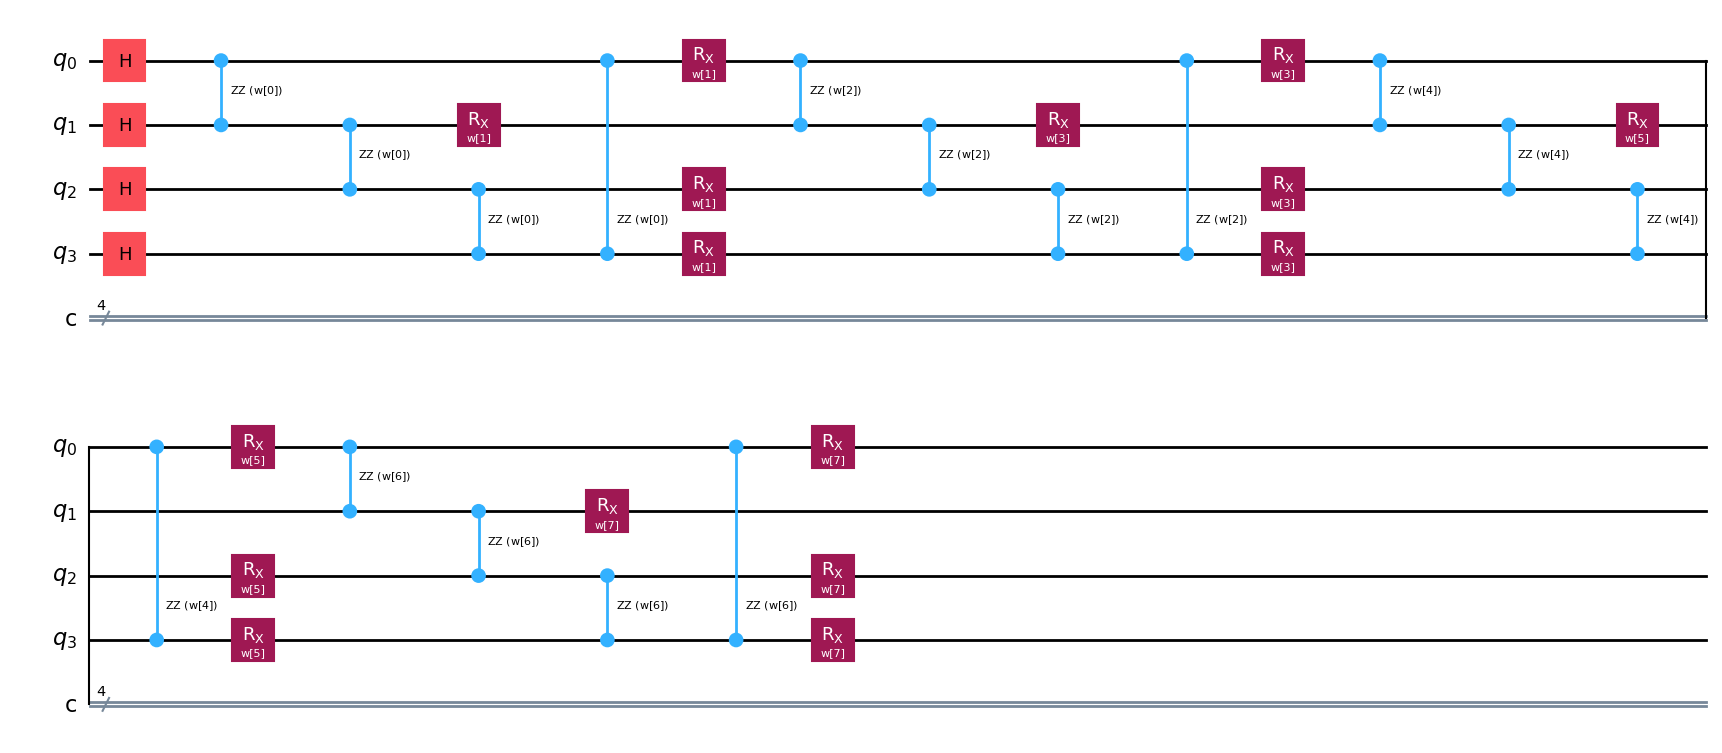

In [4]:
"""Circuit construction"""
layer = 4  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = layer * 2  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_HVA_TIFM(weights):
    circ = QuantumCircuit(num_q, num_q)

    for j in range(num_q):
        circ.h(j) 

    for i in range(layer):
        ## Odd layers
        for j in range(num_q):
            circ.rzz(weights[2 * i], j , (j + 1) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(num_q):
            circ.rx(weights[2 * i + 1], j)  ## YY gates in odd sum
            # weights  [1]


    return circ 

qc = circuit_HVA_TIFM(weights)
# print(qc)
qc.draw("mpl")
# Latex drawing
# qc.draw(output="latex")


In [5]:
simulator = AerSimulator()

def estimate_loss(WEIGHTS, SHOTS):

    estimate_1 = 0
    estimate_2 = 0

    ########################### ZZ
    qc = circuit_HVA_TIFM(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_1 += 1
            else:
                estimate_1 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_1 += 1
        else:
            estimate_1 += -1
            
    estimate_1 = estimate_1/SHOTS



    ########################### X
    qc = circuit_HVA_TIFM(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q):
            if c_i[num_q-1-j] == '0':
                estimate_2 += 1
            else:
                estimate_2 += -1

    estimate_2 = estimate_2/SHOTS

    estimate = estimate_1 + Delta*estimate_2

    return estimate



def expectation_loss(WEIGHTS):
    qc = circuit_HVA_TIFM(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


def fidelity(WEIGHTS):
    qc = circuit_HVA_TIFM(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2


def std(WEIGHTS):
    qc = circuit_HVA_TIFM(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hmat_sqaured =  Hmat @ Hmat
    Hmat_sqauredpsi = Hmat_sqaured.dot(psi)
    var = np.inner(np.conjugate(psi),Hmat_sqauredpsi) - expectation_loss(WEIGHTS)**2
    return np.sqrt(np.real(var))



In [6]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

print(expectation_loss(weights))
print(std(weights))
print(expectation_loss(weights)/std(weights))
print(ground_e)

# Check if the observed values from the simulator follow a normal distribution
# Essentially, this is to check whether the estimate_loss function is correct
# It takes a long time
shots = 1000
if False:
    true_value = expectation_loss(weights)

    num_trials = 3000
    estimate_results = [estimate_loss(weights, shots) for _ in range(num_trials)]

    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=15, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


-1.8226752431957025
1.2366743161932212
-1.4738522659760025
-4.271558410139714


In [7]:
weights_dict = {}

from algo.utils import mse

#################### Odd layers with RZZ gates
omegas_1 = [2]
interp_nodes_1 = np.linspace(0, 2 * np.pi, 2 * len(omegas_1) + 1, endpoint=False)
inverse_interp_matrix_1 = np.linalg.inv(interp_matrix(interp_nodes_1, omegas_1))
print(f"Minimum MSE: {mse(interp_nodes_1, omegas_1)}")

#################### Even layers with RX gates
omegas_2 = [2]
interp_nodes_2 = np.linspace(0, 2 * np.pi, 2 * len(omegas_2) + 1, endpoint=False)
inverse_interp_matrix_2 = np.linalg.inv(interp_matrix(interp_nodes_2, omegas_2))
print(f"Minimum MSE: {mse(interp_nodes_2, omegas_2)}")

# Construct weights_dict
weights_dict = {}
for j in range(num_p): 
    if j % 2 == 0:  # Odd layers with RZZ gates
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas_1,
            'scale_factor': 2.0,
            'interp_nodes': interp_nodes_1,
            'inverse_interp_matrix': inverse_interp_matrix_1,
        }
    elif j % 2 == 1:  # Even layers with RYY+RXX gates
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas_2,
            'scale_factor': 2.0,
            'interp_nodes': interp_nodes_2,
            'inverse_interp_matrix': inverse_interp_matrix_2,
        }
    
# Print example results
print(weights_dict['weights_0'])
print(weights_dict['weights_1'])
print(len(weights_dict))


Minimum MSE: 1.9999986666675558
Minimum MSE: 1.9999986666675558
{'omegas': [2], 'scale_factor': 2.0, 'interp_nodes': array([0.       , 2.0943951, 4.1887902]), 'inverse_interp_matrix': array([[ 4.71404521e-01,  4.71404521e-01,  4.71404521e-01],
       [ 6.66666667e-01, -3.33333333e-01, -3.33333333e-01],
       [-4.48691293e-16, -5.77350269e-01,  5.77350269e-01]])}
{'omegas': [2], 'scale_factor': 2.0, 'interp_nodes': array([0.       , 2.0943951, 4.1887902]), 'inverse_interp_matrix': array([[ 4.71404521e-01,  4.71404521e-01,  4.71404521e-01],
       [ 6.66666667e-01, -3.33333333e-01, -3.33333333e-01],
       [-4.48691293e-16, -5.77350269e-01,  5.77350269e-01]])}
8


In [8]:
# Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

from algo.utils import check_is_trigometric  # Assuming check_is_trigometric is defined in utils module
from algo.utils import filter_omegas

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

COMPACT_OMEGAS= []
# Loop over each weight index and check trigonometric interpolation
for j in range(num_p):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    estimated_coefficients = check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)

    compact_omegas = filter_omegas(estimated_coefficients, omegas, threshold=1e-7)

    print('compact_omegas = ', compact_omegas)
    COMPACT_OMEGAS.append(compact_omegas)

for i in range(len(COMPACT_OMEGAS)):
    # print('index to check = ', i)
    print('\nFINAL COMPACT OMEGAS')
    print(i, COMPACT_OMEGAS[i])



 index to check =  0
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [ 1.06607841 -2.91779726  0.12659264]
compact_omegas =  [2]

 index to check =  1
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-3.02692557  0.01442723  0.17592009]
compact_omegas =  [2]

 index to check =  2
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [ 0.94578495 -2.39486435  1.13400066]
compact_omegas =  [2]

 index to check =  3
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-0.63661768  1.32893151  1.5922748 ]
compact_omegas =  [2]

 index to check =  4
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [0.38211505 2.85124083 2.39170376]
compact_omegas =  [2]

 index to check =  5
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-0.48358692  1.17724635 -1.03831246]
compact_omegas =  [2]

 index to check =  6
omegas =  [2]
Consist

In [9]:
# initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
n_shot = 1000
print(f"Ground state energy: {ground_e}")

Ground state energy: -4.271558410139714


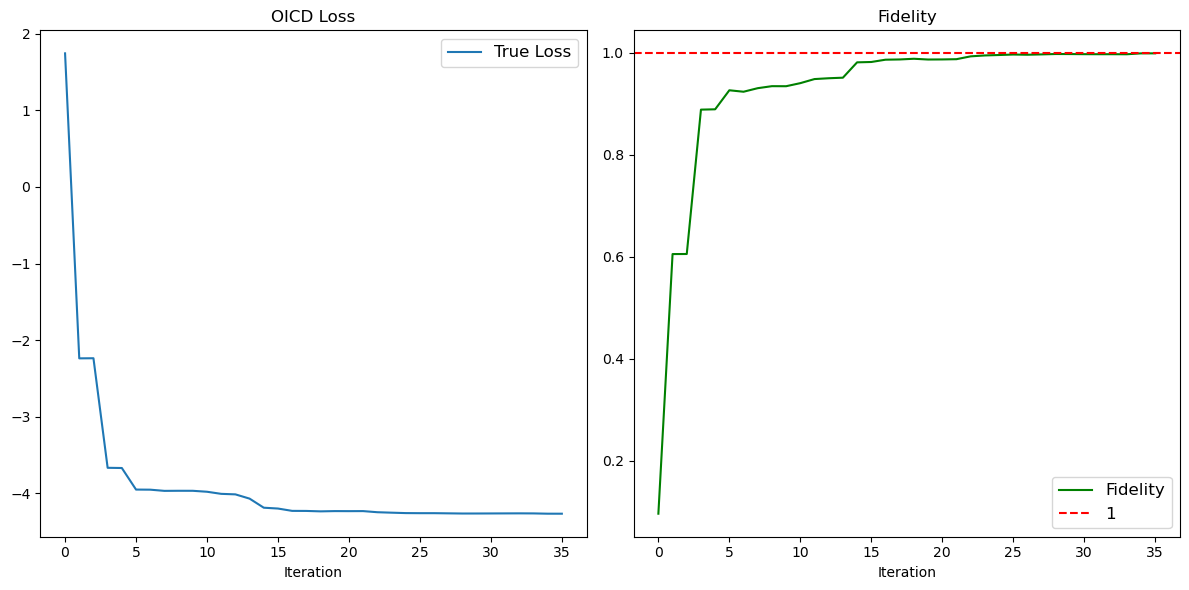

[OICD] Iter: 34, 2(8), Best loss: -4.2665, Cur. loss: -4.2665, Best Fid.: 0.9990, Cur. Fid.: 0.9990:   0%|          | 34/15000 [00:11<1:24:13,  2.96it/s]


In [10]:
# OICD Optimization
from algo.oicd import oicd

num_iter = 15000
# Run OICD
final_weights_oicd, best_expected_record_value_oicd, best_fid_record_value_oicd, func_oicd, _, _ = oicd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=False,
    use_pratical_interp_flag=True,
    use_local_solvers_flag=False,
    use_global_solvers_flag = False,
    use_eigen_method_flag = True,
    # subproblem_method='BFGS',
    # subproblem_iter=None,
    use_exact_update_frequencey_1_flag = False,
    exact_mode=False, # for testing purpose, no noisy loss
    plot_flag=True,
    plot_argmin_flag = False,
)


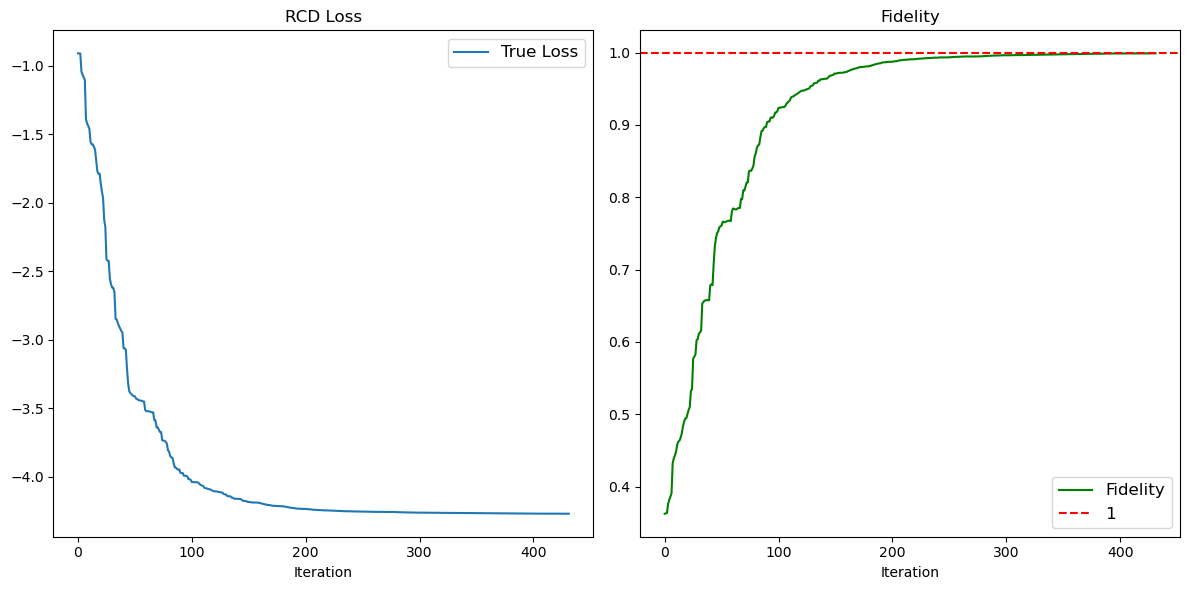

[RCD] Iter: 438, 4(8), Best loss: -4.2687, Cur. loss: -4.2687, Best Fid.: 0.9990, Cur. Fid.: 0.9990:   3%|▎         | 438/15000 [00:54<30:28,  7.96it/s]


In [22]:
# RCD Optimization
from algo.rcd import rcd

num_iter = 15000
# Run RCD
final_weights_rcd, best_expected_record_value_rcd, best_fid_record_value_rcd, func_rcd, _, _= rcd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=False,
    learning_rate=0.01,
    decay_step=10,
    decay_rate=-1,
    decay_threshold=1e-4,
    exact_mode=False,
    plot_flag=True,
)


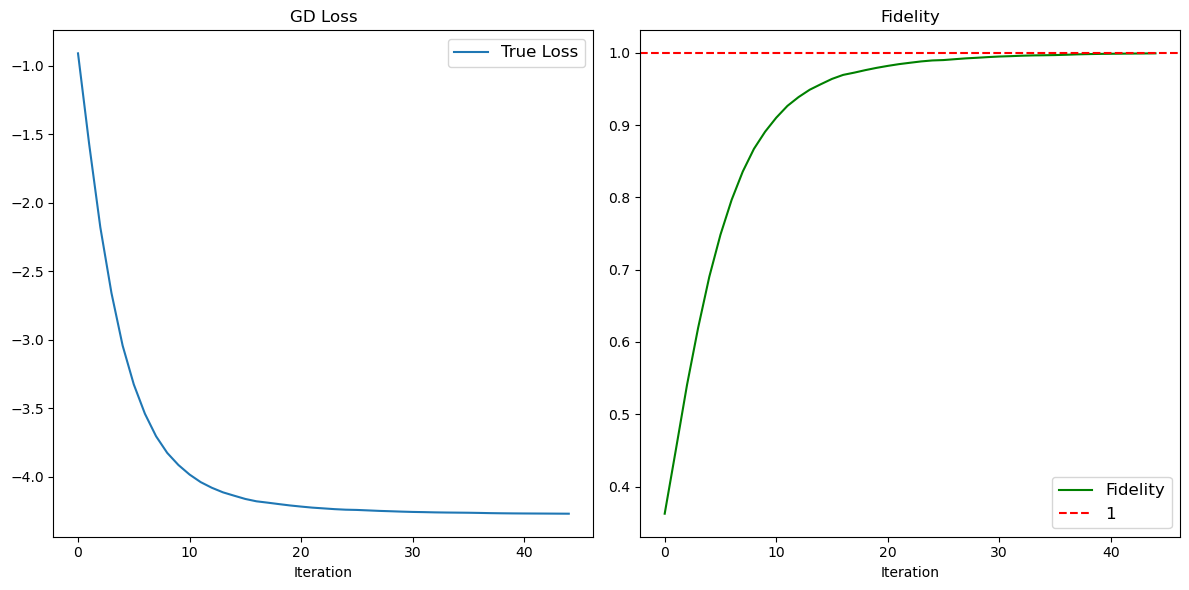

[GD] Iter: 43, Best loss: -4.2688, Cur. loss: -4.2688, Best Fid.: 0.9991, Cur. Fid.: 0.9991:   4%|▍         | 43/1000 [00:36<13:35,  1.17it/s]


In [ ]:
# Gradient Descent Optimization
from algo.gd import gd

num_iter = 15000
# Run GD
final_weights_gd, best_expected_record_value_gd, best_fid_record_value_gd, func_gd, _, _ = gd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    learning_rate=0.01,
    exact_mode=False,
    plot_flag=True,
)


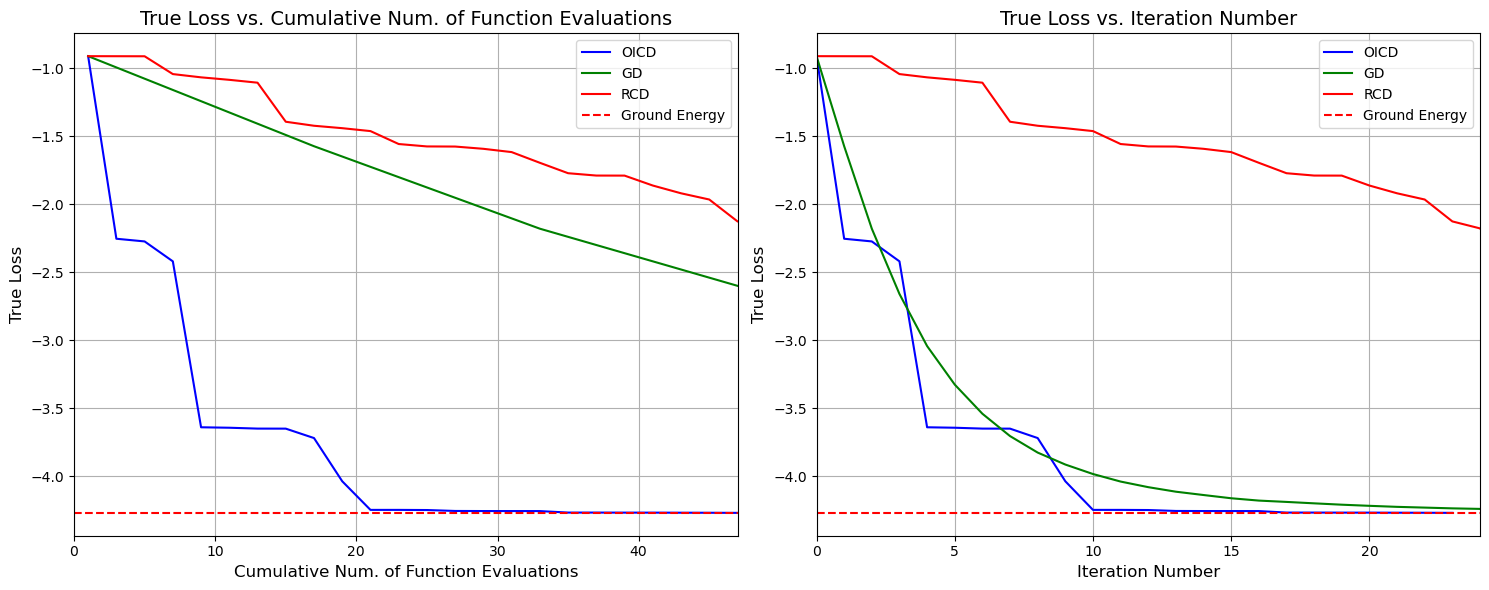

In [24]:
# Create a 1x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is the function value
axs[0].plot(func_oicd, best_expected_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, best_expected_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, best_expected_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('True Loss', fontsize=12)
axs[0].set_title('True Loss vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*1
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is the function value
axs[1].plot(best_expected_record_value_oicd, label='OICD', color='blue')
axs[1].plot(best_expected_record_value_gd, label='GD', color='green')
axs[1].plot(best_expected_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('True Loss', fontsize=12)
axs[1].set_title('True Loss vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(best_expected_record_value_oicd), len(best_expected_record_value_gd), len(best_expected_record_value_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Adjust the layout automatically to avoid overlapping labels between subplots
plt.tight_layout()

# Show the plot
plt.show()


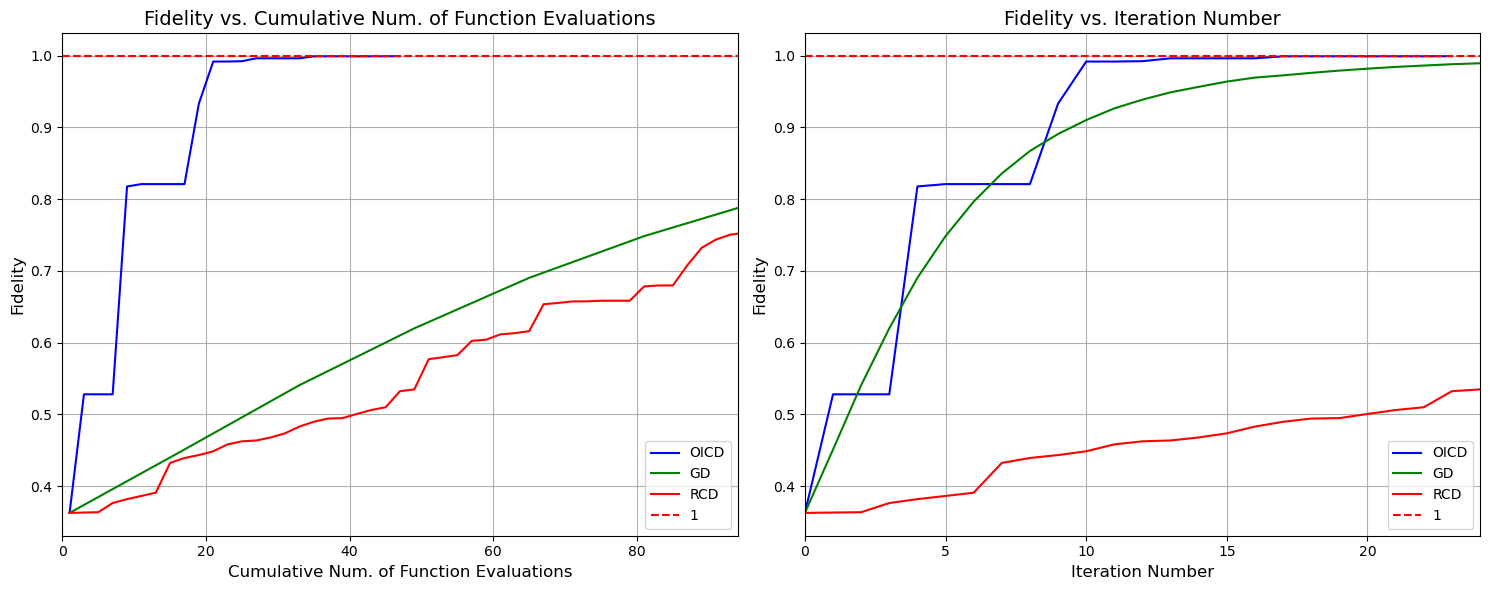

In [25]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is Fidelity
axs[0].plot(func_oicd, best_fid_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, best_fid_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, best_fid_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=1, color='r', linestyle='--', label='1')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('Fidelity', fontsize=12)
axs[0].set_title('Fidelity vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*2
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is Fidelity
axs[1].plot(best_fid_record_value_oicd, label='OICD', color='blue')
axs[1].plot(best_fid_record_value_gd, label='GD', color='green')
axs[1].plot(best_fid_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=1, color='r', linestyle='--', label='1')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('Fidelity', fontsize=12)
axs[1].set_title('Fidelity vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(best_fid_record_value_oicd), len(best_fid_record_value_gd), len(best_fid_record_value_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Automatically adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()
